In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np
import csv
import matplotlib.patches as mpatches
import datetime as dt
import os
import cv2
import numpy as np
from shapely.geometry.polygon import Polygon
from shapely import wkt
from shapely.geometry.point import Point
from shapely.geometry import Polygon
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pandas as pd
import logging
from sunpy.coordinates.ephemeris import get_horizons_coord
from sunpy.net import attrs as a
from sunpy.net import Fido
from pixiedust.display import *

In [54]:
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-16s %(levelname)-4s %(message)s')
logger = logging.getLogger('HEKEventAnalyzer')
date_format = '%Y%m%d%H%M'

class EVENT_TYPE:
    """
    The event types of the solar events. (More: https://www.lmsal.com/hek/VOEvent_Spec.html)
    """
    AR = 'ar'  # Active Region
    CH = 'ch'  # Coronal Hole
    FI = 'fi'  # Filament, Kanzelhöhe

    CE = 'ce'  # Coronal Mass Ejection (CME)
    FL = 'fl'  # Flare
    SG = "sg"  # Sigmoid

    @staticmethod
    def convert(et):
        return {
            'ar': EVENT_TYPE.AR,
            'ch': EVENT_TYPE.CH,
            'ce': EVENT_TYPE.CE,
            'fi': EVENT_TYPE.FI,
            'fl': EVENT_TYPE.FL,
        }.get(et, 'ar')  # default is 'ar'


class SpatioTemporalEvent:
    def __init__(self,
                 event_type: EVENT_TYPE,
                 start_time: dt.datetime,
                 end_time: dt.datetime,
                 hpc_coord: (Point, str),
                 hpc_bbox: (Polygon, str),
                 hpc_boundcc: (Polygon, str),
                 kb_archivid: str):
        """
        :param event_type: The event for which the results are returned.
        :param start_time: Start time of the event type.
        :param end_time: End Time of the event Type.
        :param hpc_coord: coordinates of the center of the bounding box.
        :param hpc_bbox: bounding box of the polygon.
        :param hpc_boundcc: polygon of the detected event (if present).
        :param kb_archivid: Unique id for each event type.
        """
        self.event_type: EVENT_TYPE = event_type
        self.start_time: dt.datetime = start_time
        self.end_time: dt.datetime = end_time
        self.hpc_coord: (Point, str) = hpc_coord
        self.hpc_bbox: (Polygon, str) = hpc_bbox
        if(hpc_boundcc):
            self.hpc_boundcc: (Polygon, str) = hpc_boundcc
        self.kb_archivid: str = kb_archivid

    @classmethod
    def from_dict(cls, instance: dict):
        obj = cls.__new__(cls)
        super(SpatioTemporalEvent, obj).__init__()
        obj.event_type = instance['event_type']
        obj.start_time = instance['event_starttime']
        obj.end_time = instance['event_endtime']
        obj.hpc_coord = instance['hpc_coord']
        obj.hpc_bbox = instance['hpc_bbox']
        if instance['hpc_boundcc'] != '':
            obj.hpc_boundcc = instance['hpc_boundcc']
        else:
            obj.hpc_boundcc = None
        obj.kb_archivid = instance['kb_archivid']
        return obj

    @property
    def event_type(self):
        return self.__event_type

    @event_type.setter
    def event_type(self, event_type):
        if isinstance(event_type, EVENT_TYPE):
            self.__event_type = event_type
        elif isinstance(event_type, str):
            self.__event_type = EVENT_TYPE.convert(event_type)

    @property
    def start_time(self):
        return self.__start_time

    @start_time.setter
    def start_time(self, start_time):
        if isinstance(start_time, dt.datetime):
            self.__start_time = start_time
        elif isinstance(start_time, str):
            self.__start_time = dt.datetime.strptime(
                start_time, '%Y-%m-%dT%H:%M:%S')
        else:
            raise AttributeError

    @property
    def end_time(self):
        return self.__end_time

    @end_time.setter
    def end_time(self, end_time):
        if isinstance(end_time, dt.datetime):
            self.__end_time = end_time
        elif isinstance(end_time, str):
            self.__end_time = dt.datetime.strptime(end_time, '%Y-%m-%dT%H:%M:%S')
        else:
            raise AttributeError

    @property
    def hpc_coord(self):
        return self.__hpc_coord

    @hpc_coord.setter
    def hpc_coord(self, hpc_coord):
        if isinstance(hpc_coord, Point):
            self.__hpc_coord = hpc_coord
        elif isinstance(hpc_coord, str):
            self.__hpc_coord = wkt.loads(hpc_coord)
        else:
            raise AttributeError

    @property
    def hpc_bbox(self):
        return self.__hpc_bbox

    @hpc_bbox.setter
    def hpc_bbox(self, hpc_bbox):
        if isinstance(hpc_bbox, Polygon):
            self.__hpc_bbox = hpc_bbox
        elif isinstance(hpc_bbox, str):
            self.__hpc_bbox = wkt.loads(hpc_bbox)
        else:
            raise AttributeError

    @property
    def hpc_boundcc(self):
        return self.__hpc_boundcc

    @hpc_boundcc.setter
    def hpc_boundcc(self, hpc_boundcc):
        if hpc_boundcc is None:
            self.__hpc_boundcc = None
        if isinstance(hpc_boundcc, Polygon):
            self.__hpc_boundcc = hpc_boundcc
        elif isinstance(hpc_boundcc, str):
            self.__hpc_boundcc = wkt.loads(hpc_boundcc)
        else:
            # raise AttributeError
            self.__hpc_boundcc = None

    @property
    def kb_archivid(self):
        return self.__kb_archivid

    @kb_archivid.setter
    def kb_archivid(self, kb_archivid):
        self.__kb_archivid = kb_archivid

    def to_dict(self):
        dict = {'event_type': self.event_type,
                'start_time': self.start_time,
                'end_time': self.end_time,
                'hpc_coord': self.hpc_coord,
                'hpc_bbox': self.hpc_bbox,
                'hpc_boundcc': self.hpc_boundcc,
                'kb_archivid': self.kb_archivid
                }
        return dict

    
def convert_boundingpoints_to_pixelunit(polygon: Polygon, cdelt1, cdelt2, crpix1, crpix2, original_w, shrinkage_ratio=1):
    """
    This method converts the points coordinates from arc-sec unit to pixel unit, and meanwhile
    makes 2 modifications:
        1. Vertical mirror of the points (this is required if JPG format is being used)
        2. Shrinkage of points (required if downsized images are being used.)

    :param polygon: a list of points forming a closed shape.
    :param cdelt1: fits/jp2 header information to scale in x direction
    :param cdelt2: fits/jp2 header information to scale in y direction
    :param crpix1: fits/jp2 header information to shift in x direction
    :param crpix2: fits/jp2 header information to shift in y direction
    :param original_w: the width of the original images. It is assumed that the images
    are in square shape, hence width and height are equal.
    :param shrinkage_ratio: a float point that indicates the ratio (original_w/new_size).
    For example, for 512 X 512 image, it should be 8.0.
    :return: a polygon object (from Shapely package) and None if the list was empty. If you need
            a list of tuples (x, y) instead, you can convert it using `poly = poly.exterior.coords'
    """
    points = polygon.exterior.coords
    b = [(float(v[0]) / cdelt1 + crpix1, float(v[1]) / cdelt2 + crpix2)
         for v in points]

    # TODO for the currated image params dataset these need to be mirror horizontally, why not here?
    #b = [(v[0] / shrinkage_ratio, (original_w - v[1]) / shrinkage_ratio)
    b = [(v[0] / shrinkage_ratio, (v[1]) / shrinkage_ratio)
         for v in b]

    return Polygon(b)


def convert_events_to_pixelunits(events_df: pd.DataFrame, img_header, original_width=4096, shrinkage_factor=8):
    all_polygons = []
    all_bboxes = []

    for i, event in events_df.iterrows():
        ste = SpatioTemporalEvent.from_dict(event)

        if(ste.hpc_boundcc is not None):
            # hpc_boundcc is optional
            poly_converted = convert_boundingpoints_to_pixelunit(polygon=ste.hpc_boundcc,
                                                                 cdelt1=img_header['CDELT'],
                                                                 cdelt2=img_header['CDELT'],
                                                                 crpix1=img_header['X0'],
                                                                 crpix2=img_header['Y0'],
                                                                 original_w=original_width,
                                                                 shrinkage_ratio=shrinkage_factor)
            all_polygons.append(poly_converted)

        bbox_converted = convert_boundingpoints_to_pixelunit(polygon=ste.hpc_bbox,
                                                             cdelt1=img_header['CDELT'],
                                                             cdelt2=img_header['CDELT'],
                                                             crpix1=img_header['X0'],
                                                             crpix2=img_header['Y0'],
                                                             original_w=original_width,
                                                             shrinkage_ratio=shrinkage_factor)

        all_bboxes.append(bbox_converted)

    return (all_polygons, all_bboxes)

def get_meta_info(image_path, index_path):
    #https://docs.sunpy.org/en/stable/api/sunpy.coordinates.ephemeris.get_horizons_coord.html#sunpy.coordinates.ephemeris.get_horizons_coord
    index_file = pd.read_csv(index_path)
    index_file["timestamp"] = pd.to_datetime(index_file['timestamp'])
    index = index_file[index_file["file_name"]==image_path.name].iloc[0]
    
    coords = get_horizons_coord('SDO', index.timestamp)
    # TODO how to obtain just the FITS header information?
    # QUALITY,DSUN,X0,R_SUN,Y0,CDELT,FILE_NAME
    # 1073741824,147126420000.0,2053.23,1628.7837,2045.8,0.599076,2012-01-02T060000__171.jpeg
    header = {
        'DSUN': 147126420000.0,
        'X0': 2053.23,
        'Y0': 2045.8, 
        "R_SUN": 1628.7837,
        "CDELT": 0.599076,
        "timestamp": index.timestamp
    }
    
    return header

def get_date_ranges(start, end, freq="d"):
    # retrieve daily ranges between start and end to not overload the HEK API

    dates = pd.date_range(start=start, end=end,
                              freq=freq).to_pydatetime().tolist()

    dates[0] = start
    if(dates[len(dates) - 1] < end):
        dates.append(end)

    ranges = []
    for i in range(0, len(dates) - 1):
        t_start = dates[i]
        if(i < len(dates) - 1):
            t_end = dates[i + 1]
        else:
            t_end = end

        ranges.append((t_start, t_end))

    return ranges
    
def load_events_from_hek(start: dt.datetime, end: dt.datetime, event_type: str):
    """
    Retrieves a set of events from HEK and stores it in the local database
    """
    date_ranges = get_date_ranges(start, end)
    total_events = 0
    all_events_dfs = []
    for t_start, t_end in date_ranges:
        event_query = a.hek.EventType(event_type)
        result = Fido.search(a.Time(start, end), event_query)
        col_names = [name for name in result["hek"].colnames if len(
            result["hek"][name].shape) <= 1]
        events_df = result["hek"][col_names].to_pandas()
        total_events = total_events + len(events_df)
        all_events_dfs.append(events_df)
        
    logger.info(f"retrieved a total of {total_events} from HEK")
    return pd.concat(all_events_dfs)
        
def load_boxes(src_img_full_path, index_path, hek_event_type='AR', instrument="AIA", allowed_time_diff_seconds=1800):
    meta = get_meta_info(src_img_full_path, index_path)
    timestamp = meta["timestamp"]
    start = timestamp - dt.timedelta(seconds=allowed_time_diff_seconds)
    end = timestamp + dt.timedelta(seconds=allowed_time_diff_seconds)
    events_df = load_events_from_hek(start, end, hek_event_type)

    if len(events_df) < 1:
        logger.warning(f"no events found")
        return None, None, None

    # filter events that were observed in the respective wavelength, possibly also filter by feature extraction method
    events_df = events_df[events_df['obs_observatory'].str.contains("SDO")]
    logger.info(f"after filter {len(events_df)} events")

    hek_bboxes, hek_polygons = convert_events_to_pixelunits(events_df, meta)
    return events_df, hek_bboxes, hek_polygons

In [55]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# https://github.com/dfouhey/sdodemo/blob/master/vis_demo.py
import numpy as np
import matplotlib.pyplot as plt
import sunpy
from sunpy.visualization.colormaps import cm
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image

#Channels that correspond to HMI Magnetograms 
HMI_WL = ['bx','by','bz']
#A colormap for visualizing HMI
HMI_CM = LinearSegmentedColormap.from_list("bwrblack", ["#0000ff","#000000","#ff0000"])

def channelNameToMap(name):
    """Given channel name, return colormap"""
    return HMI_CM if name in HMI_WL else cm.cmlist.get('sdoaia%d' % int(name))

def getClip(X,name):
    """Given an image and the channel name, get the right clip"""
    return getSignedPctClip(X) if name in HMI_WL else getPctClip(X)

def getPctClip(X):
    """Return the 99.99th percentile"""
    return (0,np.quantile(X.ravel(),0.999))

def getSignedPctClip(X):
    """Return the 99.99th percentile by magnitude, but symmetrize it so 0 is in the middle"""
    v = np.quantile(np.abs(X.ravel()),0.999)
    return (-v,v)

def vis(X, cm, clip):
    """Given image, colormap, and a clipping, visualize results"""
    Xc = np.clip((X-clip[0])/(clip[1]-clip[0]),0,1)
    Xcv = cm(Xc)
    return (Xcv[:,:,:3]*255).astype(np.uint8)

def display_img(img_path, hek_bboxes, hek_polygons, channelName):
    if hek_bboxes is None or hek_polygons is None:
        return 
    plt.clf()
    X = np.load(img_path)['x'].astype(np.float64)
    V = vis(X, channelNameToMap(channelName), getClip(X, channelName))

    img = Image.fromarray(V)
    #img = img.convert('RGB')
    img_draw = ImageDraw.Draw(img)

    fig = plt.figure(figsize=(12, 12))

    for poly in hek_polygons:
        poly = poly.exterior.coords
        img_draw.line(poly, fill="red", width=1)
        for point in poly:
            img_draw.ellipse(
                (point[0] - 2, point[1] - 2, point[0] + 2, point[1] + 2), fill="red")

    for bbox in hek_bboxes:
        bbox = bbox.exterior.coords
        img_draw.line(bbox, fill="blue", width=1)
        for point in bbox:
            img_draw.ellipse(
                (point[0] - 2, point[1] - 2, point[0] + 2, point[1] + 2), fill="blue")

    plt.axis('off')
    title = img_path.name
    plt.title(title)

    red_patch = mpatches.Patch(color='red', label='HEK bounding box')
    blue_patch = mpatches.Patch(color='blue', label='HEK exact bounding box')
    
    plt.legend(handles=[red_patch, blue_patch])

    plt.imshow(img)


In [57]:
root_dir = Path(" /nas08-data02/astroml_data/stanford_machine_learning_dataset_for_sdo_extracted/")
src_img_full_path = root_dir / Path("2012/01/02/AIA20120102_0706_0171.npz")
index_path = root_dir / Path("index.csv")

events_df, hek_bboxes, hek_polygons = load_boxes(src_img_full_path, index_path, hek_event_type='AR')

2022-02-13 20:54:30,599 sunpy            INFO Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac


INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac [sunpy.coordinates.ephemeris]
<SkyCoord (HeliographicStonyhurst: obstime=2012-01-02T07:06:00.000000000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)
    (0.00121885, -3.11180138, 0.98348855)>


2022-02-13 20:54:32,309 HEKEventAnalyzer INFO retrieved a total of 9 from HEK
2022-02-13 20:54:32,314 HEKEventAnalyzer INFO after filter 6 events


In [59]:
display(events_df)

gs_thumburl,comment_count,hpc_bbox,meanphotoenergydensity,frm_humanflag,hgc_coord,ar_spotarearepruncert,event_coordsys,obs_levelnum,hpc_coord,event_npixels,gs_imageurl,ar_polarity,totalenergydensityunit,frm_paramset,hrc_coord,event_starttime,ar_mtwilsoncls,event_type,meantwistalpha,intensmin,obs_meanwavel,frm_url,bound_chaincode,totalphotoenergy,noposition,ar_spotarearepr,active,intensmax,frm_versionnumber,ar_pilcurvature,area_uncert,obs_dataprepurl,hpc_geom,hgc_bbox,intensmedian,chaincodetype,obs_channelid,ar_spotareareprunit,event_clippedspatial,ar_noaaclass,SOL_standard,event_avg_rating,eventtype,intensunit,hpc_boundcc,event_mapurl,frm_contact,meanvertcurrentdensity,ar_penumbracls,intensmean,bound_ccstartc1,frm_name,area_atdiskcenter,frm_identifier,obs_observatory,event_description,ar_spotarearaw,unsignedflux,boundbox_c2ur,magfluxunit,highshearareapercent,obs_firstprocessingdate,maxmagfieldstrengthunit,sharp_noaa_ars,boundbox_c2ll,frm_institute,hrc_bbox,refs_orig,meangradienthorz,gwill,ar_mcintoshcls,event_maskurl,bound_ccstartc2,ar_spotarearawunit,gs_movieurl,event_score,event_expires,hrc_boundcc,event_probability,intensvar,frm_daterun,currentdensityunit,highsheararea,event_coordunit,hpc_y,hpc_x,search_instrument,ar_numspots,kb_archivdate,kb_archivist,intenstotal,sum_overlap_scores,unsignedvertcurrent,hgs_boundcc,intensskew,obs_includesnrt,rasterscan,obs_wavelunit,kb_archivid,search_frm_name,meaninclinationgamma,currenthelicityunit,boundbox_c1ur,ar_noaanum,area_atdiskcenteruncert,boundbox_c1ll,absnetcurrenthelicity,meancurrenthelicity,event_importance_num_ratings,highshearareaunit,ar_compactnesscls,currentunit,event_testflag,maxmagfieldstrength,event_c2error,hrc_r,hgs_y,obs_title,hgs_x,hcr_checked,frm_specificid,totalphotoenergydensity,event_title,gwillunit,ar_sumnegsignedflux,obs_instrument,ar_neutrallength,event_c1error,revision,hpc_radius,meanshearangle,event_endtime,ar_spotarearawuncert,meanenergydensityunit,event_importance,meangradienttotal,event_coord2,event_coord3,event_coord1,search_observatory,ar_sumpossignedflux,area_raw,meangradientvert,concept,ar_axislength,event_pixelunit,hgc_boundcc,log_r_value,totalphotoenergyunit,hgc_x,hrc_a,hgc_y,gs_galleryid,twistunit,ar_lengthunit,hgs_coord,ar_zurichcls,bound_ccnsteps,intenskurt,event_clippedtemporal,gradientunit,rasterscantype,search_channelid,unsignedcurrenthelicity,hgs_bbox,area_unit,savncpp,obs_lastprocessingdate,refs
http://sdowww.lmsal.com/sdomedia/ssw/ssw_client/data/ssw_service_120112_192417_28227/www/ssw_cutout_171_context_thumb.gif,0,"POLYGON((-386.7 -418.5,-184.5 -418.5,-184.5 -185.7,-386.7 -185.7,-386.7 -418.5))",None,false,POINT(85.456894 -22.444622),None,UTC-HPC-TOPO,1.5,POINT(-263.591 -326.841),45671,http://sdowww.lmsal.com/sdomedia/ssw/ssw_client/data/ssw_service_120112_192417_28227/www/ssw_cutout_171_context_full.gif,None,,"image171 : calibrated image 171 A ; image195 : calibrated image 195/193 A; spocaPreprocessing=DivExpTime,ALC,DivMedian; spocaClassifierType=HPCM2; spocaNumberclasses=4; spocaChannels=[AIA_171,AIA_193]; spocaPrecision=0.00150000; spocaRadiusRatio=1.20; spocaBinsize=0.01,0.01; spocaSegmentationType=threshold; spocaVersion=2.00; intensitiesStatsPreprocessing=NAR,DivExpTime; intensitiesStatsRadiusRatio=0.95; trackingDeltat=14400; trackingOverlap=2; trackingNumberImages=6; spocaCenters=(0.4768,0.6417),(0.9845,0.9871),(2.0143,2.6230),(5.6095,5.5814)",POINT(0.430543700341904 141.114489351065),2012-01-02T04:00:37,,AR,None,452.089,1.71e-06,http://sdoatsidc.oma.be/web/sdoatsidc/SoftwareSPoCA,"POLYGON((-386.7 -378.3,-386.1 -377.7,-365.7 -341.7,-276.3 -287.7,-272.1 -247.5,-227.1 -219.3,-215.7 -185.7,-184.5 -254.7,-228.3 -309.3,-203.1 -357.9,-212.1 -417.3,-274.5 -396.9,-344.1 -415.5,-386.7 -378.3))",None,false,None,true,4411.37,1,None,676454980,,0103000000010000000E00000033333333332B78C0CDCCCCCCCCA477C09A999999992178C033333333339B77C03333333333DB76C033333333335B75C0CDCCCCCCCC4471C03333333333FB71C09A999999990171C00000000000F06EC03333333333636CC09A

<Figure size 432x288 with 0 Axes>

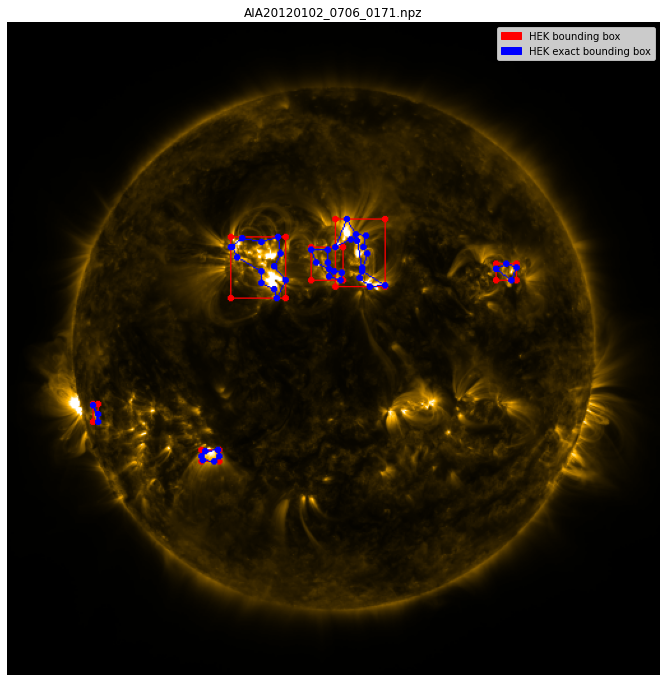

In [60]:
display_img(src_img_full_path, hek_bboxes, hek_polygons, channelName=171)